<a href="https://colab.research.google.com/github/Razany98/BERT_FineTuning/blob/main/BERT_Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Requirements

Import Huggingface modules

In [ ]:
# Install necessary libraries
!pip install transformers datasets evaluate accelerate scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
%%writefile requirements.txt
transformers
datasets
evaluate
accelerate

Writing requirements.txt


In [ ]:
! pip install -r requirements.txt

In [ ]:
# Import required libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
import pandas as pd
import numpy as np


In [ ]:
# Check if GPU is available (optional but recommended for faster training)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data Load and Preprocess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
train = pd.read_csv("/content/drive/MyDrive/Text_Mining/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Text_Mining/test.csv")

# Sample a few rows only
#train = train.sample(n=60000, random_state=42).reset_index(drop=True)
#test = test.sample(n=3800, random_state=42).reset_index(drop=True)

# Rename columns for consistency
train.rename(columns={'Class Index': 'labels'}, inplace=True)
test.rename(columns={'Class Index': 'labels'}, inplace=True)

# ----> Check and adjust the labels to be in the range 0-3 <----
train['labels'] = train['labels'] - 1  # Assuming your labels start from 1
test['labels'] = test['labels'] - 1  # Assuming your labels start from 1

In [ ]:
num_rows, num_cols = train.shape, test.shape
print("Number of rows:", num_rows,"Number of columns:", num_cols)

Number of rows: (120000, 3) Number of columns: (7600, 3)


# Tokenization

In [ ]:
from datasets import Dataset  # Import Dataset from the 'datasets' library

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Title"], padding="max_length", truncation=True)

# Convert to Dataset and tokenize
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

# Model

In [ ]:
# Define the model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.to(device)  # Move the model to the chosen device (CPU or GPU)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Define Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,  # Reduced for small dataset
    per_device_eval_batch_size=4,  # Reduced for small dataset
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.733500,0.702748,0.860395,0.860283
2,0.614500,0.676142,0.862500,0.862489
3,0.344900,0.616102,0.873553,0.873206


TrainOutput(global_step=90000, training_loss=0.6346415700781677, metrics={'train_runtime': 17456.8128, 'train_samples_per_second': 20.622, 'train_steps_per_second': 5.156, 'total_flos': 9.472168083456e+16, 'train_loss': 0.6346415700781677, 'epoch': 3.0})

### Save the Model

In [ ]:
# Save the model and tokenizer
trainer.save_model("./fine_tuned_bert")  # Saves the model
tokenizer.save_pretrained("./fine_tuned_bert")  # Saves the tokenizer
print("Model and tokenizer saved successfully.")


Model and tokenizer saved successfully.


# Evaluattion

In [ ]:
# Step 9: Evaluate on Test Set
results = trainer.evaluate()
print("Test Results:", results)

Test Results: {'eval_loss': 0.6161020994186401, 'eval_accuracy': 0.8735526315789474, 'eval_f1': 0.8732055555623053, 'eval_runtime': 106.4483, 'eval_samples_per_second': 71.396, 'eval_steps_per_second': 17.849, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import classification_report

# Generate predictions on the test dataset
predictions, labels, _ = trainer.predict(test_dataset)
predicted_classes = predictions.argmax(axis=-1)


# Define class_labels
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech'] # Update with your actual class names

# Classification report
print(classification_report(labels, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       World       0.90      0.88      0.89      1900
      Sports       0.88      0.94      0.91      1900
    Business       0.84      0.82      0.83      1900
    Sci/Tech       0.87      0.86      0.86      1900

    accuracy                           0.87      7600
   macro avg       0.87      0.87      0.87      7600
weighted avg       0.87      0.87      0.87      7600



# Visualization

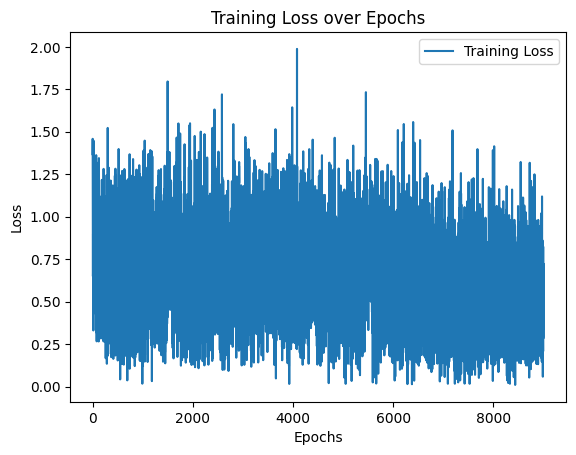

In [ ]:
import matplotlib.pyplot as plt

# Example: Plot training loss
training_loss = trainer.state.log_history
# Filter out entries that don't contain the 'loss' key
loss_entries = [entry for entry in training_loss if 'loss' in entry]
epochs = range(1, len(loss_entries) + 1) # adjust epochs range to training loss values

plt.plot(epochs, [entry['loss'] for entry in loss_entries], label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.show()

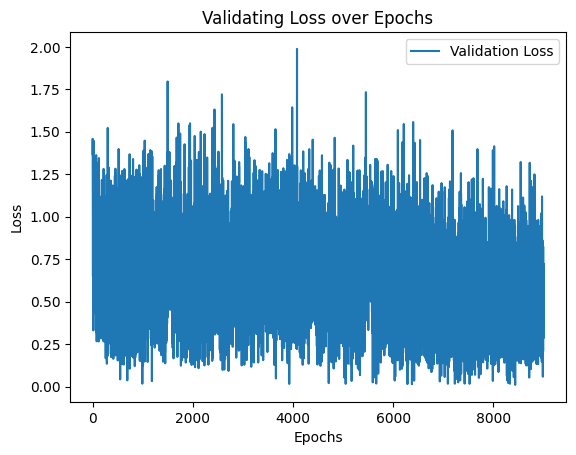

In [ ]:
import matplotlib.pyplot as plt

# Example: Plot validation loss
validation_loss = trainer.state.log_history
# Filter out entries that don't contain the 'loss' key
loss_entries = [entry for entry in validation_loss if 'loss' in entry]
epochs = range(1, len(loss_entries) + 1) # adjust epochs range to training loss values

plt.plot(epochs, [entry['loss'] for entry in loss_entries], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Validating Loss over Epochs")
plt.legend()
plt.show()